# Spending on Nondurables During the Great Recession

<p style="text-align: center;"><small><small><small>Generator: QuARK-make/notebooks_byname</small></small></small></p>

In [1]:
# Initial imports and notebook setup, click arrow to show

import matplotlib.pyplot as plt

## Import some things from cstwMPC

from tqdm import tqdm

import numpy as np
from copy import deepcopy

import HARK # Prevents import error from Demos repo
from HARK.utilities import plot_funcs
# Choose some calibrated parameters that roughly match steady state 

### There Was a Big Drop in Consumption ... 
Between the second and fourth quarters of 2018, "discretionary" spending on nondurables and services in the U.S. dropped by about 4 percent -- an unprecedented collapse.  Subsequent analyses of the Great Recession concluded that it was the large drop in consumption expenditures that turned what would otherwise have been a moderate downturn into the largest economic decline since the Great Depresssion.

<!-- Following Blinder and Deaton (1987), we exclude clothing and shoes from the "nondurables" category.  By "discretionary" services, we mean those that are not mostly predetermined or imputed from other data: Specifically: recreation services, and food services and accommodations.  Data accessed on 2020-03-27 are from https://apps.bea.gov/iTable/iTable.cfm?ReqID=19&step=2#reqid=19&step=2&isuri=1&1921=underlying

Q2: (770.703+789.047+421.153+621.281+391.462)
Q4: (773.038+786.175+302.043+621.773+387.206)
(Q4-Q2)/Q2=0.0412
-->

### ... and Uncertainty Could Induce A Drop In Consumption ...  
Increased "uncertainty" has become a popular explanation of much of what happened in the Great Recession -- including this drop.  Qualitatively, it is well known that a perceived increase in labor income uncertainty should induce more saving (less consumption) for precautionary reasons.

### ... But Is the Story _Quantitatively_ Plausible?
But if explaining a 4 percent drop in discretionary consumption would require an implausibly large increase in uncertainty, the story that uncertainty explains the consumption drop is implausible.  

### Transitory Shocks, Permanent Shocks, or Unemployment
The $\texttt{ConsIndShockConsumerType}$ model incorporates three kinds of uncertainty: Unemployment spells, during which income is reduced to some small proportion of its normal level; and, for consumers who remain employed, transitory and permanent shocks with standard deviations $\sigma_{\theta}$ and $\sigma_{\psi}$.  

### The Question:
How large an increase in the standard deviation of $\sigma_{\psi}$ would be necessary to induce a 6.4 percent drop in consumption in one quarter?  What about $\sigma_{\theta}$?  How high would the perceived unemployment probability have to be?

The first step is to create the agents we want to solve the model for.

Model set up:
- "Standard" infinite horizon consumption/savings model, with mortality and permanent and temporary shocks to income
- Ex-ante heterogeneity in consumers' discount factors
    
With this basic setup, HARK's IndShockConsumerType is the appropriate subclass of $\texttt{AgentType}$. So we need to prepare the parameters to create instances of that class.


In [2]:
from HARK.ConsumptionSaving.ConsIndShockModel import init_idiosyncratic_shocks
init_idiosyncratic_shocks_agg_SS = deepcopy(init_idiosyncratic_shocks)

In [18]:
# Calibrated and calculated parameters

PermShkVarAnn   = 0.01 # var of annual perm shk from Carroll (1992)
TranShkVarAnn   = 0.01 # var of annual tran shk from Carroll (1992)
TranShkStd      = (0.01*4)**0.5         # Converts ann var to qtr std for tran
PermShkStd      = (0.01*4/11)**0.5      # Converts ann var to qtr std for perm
PermGroFacAnn   = 1.00                  # No underlying annual idiosyncratic permanent income growth
PermGroFac      = PermGroFacAnn**0.25 # Quarterly idiosyncratic permanent income growth factor
Rfree           = 1.01/(1.0 - 1.0/240.0)# Extra idiosyncratic interest comes from Blanchard (1985) insurance 
LivPrb          = 1.0 - 1.0/240.0       # Expected life of 240 quarters = 60 years + born at 25 = lifespan 85
PermLogLevVarSS = (PermShkStd**2)/(1.0-(LivPrb**2.)*(PermGroFac**2.)) # Variance of SS dist of perm inc in levels

In [24]:
init_idiosyncratic_shocks_agg_SS['CRRA']  = 1.0                       # Log utility
init_idiosyncratic_shocks_agg_SS['Rfree'] = 1.01/(1.0 - 1.0/240.0)   # 240 quarters = 60 years + start life at 25
init_idiosyncratic_shocks_agg_SS['PermGroFac'] = [PermGroFac]        # Calculated above
init_idiosyncratic_shocks_agg_SS['PermGroFacAgg'] = 1.0              # No aggregate permanent growth
init_idiosyncratic_shocks_agg_SS['PermShkStd'] = [PermShkStd]        # std perm shocks (cstwMPC; 0.01 annually)
init_idiosyncratic_shocks_agg_SS['TranShkStd'] = [TranShkStd]        # std trans shocks to income,
init_idiosyncratic_shocks_agg_SS['UnempPrb'] = 0.07                  # Prob becoming unemp if currently emp
init_idiosyncratic_shocks_agg_SS['IncUnemp'] = 0.15                  # UI replacement rate
init_idiosyncratic_shocks_agg_SS['UnempPrbRet'] = None              # Benefits cannot be taken away after retirement
init_idiosyncratic_shocks_agg_SS['LivPrb'] = [LivPrb]                # Calculated above
init_idiosyncratic_shocks_agg_SS['DiscFac'] = 0.97             # Default intertemporal discount factor, # dummy value, will be overwritten
init_idiosyncratic_shocks_agg_SS['cycles'] = 0
init_idiosyncratic_shocks_agg_SS['T_cycle'] = 1
init_idiosyncratic_shocks_agg_SS['T_sim'] = 2000  # Number of periods to simulate (idiosyncratic shocks model, perpetual youth)
init_idiosyncratic_shocks_agg_SS['T_retire'] = 0  # Kill people off if they live this many periods or more
init_idiosyncratic_shocks_agg_SS['T_age'] = 1000  # Kill people off if they live this many periods or more
init_idiosyncratic_shocks_agg_SS['IndL'] =  10.0/9.0# Labor supply per individual (constant)
init_idiosyncratic_shocks_agg_SS['aNrmInitMean'] = np.log(0.00001), # Everyone starts with (nearly) zero assets
init_idiosyncratic_shocks_agg_SS['aNrmInitStd'] = 0.0
init_idiosyncratic_shocks_agg_SS['pLvlInitMean'] = 0.0
init_idiosyncratic_shocks_agg_SS['pLvlInitStd'] = PermLogLevVarSS**0.5 # Variance of SS distribution of permanent income
init_idiosyncratic_shocks_agg_SS['AgentCount'] = 10000 # Num people to sim

Now we import the class itself and make a baseline type.

In [25]:
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
BaselineType = IndShockConsumerType(**init_idiosyncratic_shocks_agg_SS)

For this exercise, we will introduce _ex ante_ heterogeneity, so the baseline type will be copied several times.

First, let's create a list with seven copies of our baseline type.

In [26]:
# A list in python can contain anything -- including consumers
num_consumer_types   = 7 # declare the number of types we want
ConsumerTypes = [] # initialize an empty list

for nn in range(num_consumer_types):
    # Now create the types, and append them to the list ConsumerTypes
    NewType = deepcopy(BaselineType)
    NewType.seed = nn # give each consumer type a different RNG seed
    ConsumerTypes.append(NewType)

Now we can give each of the consumer types their own discount factor. (This approximates the distribution of parameters estimated in ["The Distribution of Wealth and the Marginal Propensity to Consume"](https://www.econ2.jhu.edu/people/ccarroll/papers/cstwMPC)). 

In [27]:
# Seven types is enough to approximate the uniform distribution (5 is not quite enough)
from HARK.utilities import approxUniform

# Calibrations from cstwMPC, Table 3, http://www.econ2.jhu.edu/people/ccarroll/papers/cstwMPC/#TBL-4-1-1
# are for the version of the modelt that matches the distribution of liquid assets
bottomDiscFac  = 0.9637-0.0133
topDiscFac     = 0.9637+0.0133
DiscFac_list   = approxUniform(N=num_consumer_types,bot=bottomDiscFac,top=topDiscFac)[1]

# Now, assign the discount factors
for j in range(num_consumer_types):
    ConsumerTypes[j].DiscFac = DiscFac_list[j]
    ConsumerTypes[j].quiet   = True # Turn off some unwanted output

Our agents now exist and have a concept of the problem they face, but we still need them to solve that problem.

Once we have solved each type of consumer's individual problem, we need to know the distribution of wealth (and permanent income) that the population would achieve in the long run.

The cell below does both of those tasks, looping through the consumer types. For each one, it solves that type's infinite horizon model, then simulates 1000 periods to generate an approximation to the long run distribution of wealth.

In [29]:
# tqdm presents a pretty bar that interactively shows how far the calculations have gotten
for ConsumerType in tqdm(ConsumerTypes):
    ## We configured their discount factor above.  Now solve
    ConsumerType.solve(verbose=False)
    
    # Now simulate many periods to get to the stationary distribution
    ConsumerType.T_sim = 2000
    ConsumerType.initialize_sim()
    ConsumerType.simulate()

100%|███████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:29<00:00,  4.17s/it]


With all of that setup taken care of, let's write some functions to run our counterfactual exercise and extract the information we want.

First, let's define a simple function that merely calculates the average consumption level across the entire population in the most recent simulated period.

In [30]:
# We just merge the cNrm and pNrm lists already constructed for each ConsumerType
def calcAvgC(ConsumerTypes):
    """
    This function calculates average consumption in the economy in last simulated period,
    averaging across ConsumerTypes.
    """
    # Make arrays with all types' (normalized) consumption and permanent income level
    # The brackets indicate that the contents will be a list (in this case, of lists)
    cNrm = np.concatenate([ThisType.cNrm for ThisType in ConsumerTypes])
    pLvl = np.concatenate([ThisType.pLvl for ThisType in ConsumerTypes])
    
    # Calculate and return average consumption level in the economy
    avgC = np.mean(cNrm*pLvl) # c is the ratio to p, so C = c*p
    return avgC

Now let's create a function to run the experiment we want -- change income uncertainty, and see how consumption changes.
To keep the code block below (mostly) clean, we'll describe the procedure below step by step here, with accompanying annotations in the codeblock.

1. Initialize an empty list to hold the changes in consumption that happen after parameters change, and calculate average consumption before the change in uncertainty.
2. Loop through the new uncertainty parameter values to assign. For each parameter value:
 1. Assign the parameter value to the agents
 2. Re-solve the agent's model under that degree of uncertainty
 3. Construct a population of agents distributed according to the pre-crisis steady state
 4. Simulate one more period-- the first period after the change in risk.
 5. Calculate the population average consumption level given the new consumption rule
 6. Calculate the new average consumption level as percentage change vs the prior level.
3. Return the list of percentage changes

In [31]:
# Whenever you define a function, you should describe it (with a "docstring")
def calcConsChangeAfterUncertaintyChange(OriginalTypes,NewVals,ParamToChange):
    '''
    Calculate the change in aggregate consumption for a list of values that a 
    parameter will take on.
    
    Parameters
    ----------
    OriginalTypes : [IndShockConsumerType]
        List of consumer types, who have already had their "pre-shock" problem solved and simulated.
    NewVals : np.array
        List or array of new values that the parameter of interest will take on.
    ParamToChange : str
        Name of the income distribution parameter that will be changed.
        
    Returns
    -------
    ChangesInConsumption : [float]
        List of changes in aggregate consumption corresponding to the values in NewVals, as a percentage
        of the original aggregate consumption level.
    '''
    ChangesInConsumption = [] # Step 1
    OldAvgC = calcAvgC(OriginalTypes)

    # Step 2 (the loop over counterfactual parameter values)
    for NewVal in tqdm(NewVals):
        if ParamToChange in ["PermShkStd","TranShkStd"]:
            ThisVal = [NewVal]
        else:
            ThisVal = NewVal

        ConsumerTypesNew = deepcopy(OriginalTypes)          
        for index,ConsumerTypeNew in enumerate(ConsumerTypesNew):
            setattr(ConsumerTypeNew,ParamToChange,ThisVal) # Step 2A   
            ConsumerTypeNew.update_income_process()
            ConsumerTypeNew.solve(verbose=False) # Step 2B
            
            ConsumerTypeNew.initialize_sim() # Step 2C
            ConsumerTypeNew.aNrm = OriginalTypes[index].aNrmNow
            ConsumerTypeNew.pLvl = OriginalTypes[index].pLvlNow
            
            ConsumerTypeNew.sim_one_period() # Step 2D

        NewAvgC = calcAvgC(ConsumerTypesNew) # Step 2E
        ChangeInConsumption = 100. * (NewAvgC - OldAvgC) / OldAvgC # Step 2F
        ChangesInConsumption.append(ChangeInConsumption)

    return ChangesInConsumption # Step 3, returning the output

Our counterfactual experiment function takes three inputs-- consumer types, counterfactual values, and the name of the parameter we want to change. For the sake of convenience, let's define small functions to run the experiment for each parameter with just a single input.

In [12]:
# Trivial functions can be useful in making the logic of your program clear
def calcConsChangeAfterPermShkChange(newVals):
    return calcConsChangeAfterUncertaintyChange(ConsumerTypes,newVals,"PermShkStd")

def calcConsChangeAfterTranShkChange(newVals):
    return calcConsChangeAfterUncertaintyChange(ConsumerTypes,newVals,"TranShkStd")

def calcConsChangeAfterUnempPrbChange(newVals):
    return calcConsChangeAfterUncertaintyChange(ConsumerTypes,newVals,"UnempPrb")

Now we can finally run our experiment.  In the cell below, we generate a plot of the change in aggregate consumption vs the (underlying) standard deviation of permanent income shocks.

100%|█████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.42it/s]


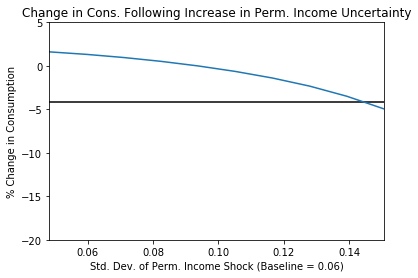

In [32]:
# Calculate the consequences of an "MIT shock" to the standard deviation of permanent shocks
ratio_min = 0.8 # minimum number to multiply uncertainty parameter by
TargetChangeInC = -4.1 # Source: see comment above
num_points = 10 # number of parameter values to plot in graphs. More=slower

# First change the variance of the permanent income shock
perm_ratio_max = 2.5 # Put whatever value in you want!  maximum number to multiply var of perm income shock by

perm_min = BaselineType.PermShkStd[0] * ratio_min
perm_max = BaselineType.PermShkStd[0] * perm_ratio_max

plt.ylabel('% Change in Consumption')
plt.xlabel('Std. Dev. of Perm. Income Shock (Baseline = ' + str(round(BaselineType.PermShkStd[0],2)) + ')')
plt.title('Change in Cons. Following Increase in Perm. Income Uncertainty')
plt.ylim(-20.,5.)
plt.hlines(TargetChangeInC,perm_min,perm_max)
# The expression below shows the power of python
plot_funcs([calcConsChangeAfterPermShkChange],perm_min,perm_max,N=num_points)

The figure shows that if people's beliefs about the standard deviation of permanent shocks to their incomes had changed from 0.06 (the default value) to about 0.014, the model would predict an immediate drop in consumption spending of about the magnitude seen in 2008.  

The question at hand is whether this is a reasonable or an unreasonable magnitude for a change in uncertainty.  Some perspective on that question is offered by the large literature that attempts to estimate the magnitude of persistent or permanent shocks to household income.  The answer varies substantially across household types, countries, and time periods, but our sense of the literature is that the whole span of the territory between 0.04 and ranging nearly up perhaps 0.16 is well populated (in the sense that substantial numbers of people or countries have been estimated to experience shocks of this magnitude).

The conclusion is that, in order for an increase in permanent income uncertainty to explain the entire drop in consumption spending, uncertainty in permanent income would have to have roughly doubled between Q2 and Q4 of 2008.  While this seems rather a large increase in uncertainty, it is by no means an absurdly large increase.  And, there is no reason to rule out the possibility that people perceived a likely change in the _level_ of their permanent income as well, which of course would translate one-for-one into a change in the appropriate level of consumption.  

The point is that it is not at all implausible, as a quantitative proposition, that an increase in uncertainty could have been responsible for a substantial portion of the decline in nondurable expenditures in the Great Recesssion.  (And it is even easier for an increase in uncertainty to induce a decline in durable goods purchases.